In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.SummaryActionScalars import SummaryActionScalars

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True # Enable LaTeX rendering

2024-08-26 19:15:17.594866: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Choose Environment

In [2]:
game = 'Seaquest' # load data: [Alien, Breakout, Boxing, Seaquest]

log_dir = f'/Users/thomasgaehtgens/Desktop/zeus_stuff/experiments/{game}_long/tensorboard_logs/{game}/' # path to data

scaling_factors = { # the number of lives in each game
    'Alien': 3,
    'Boxing': 1,
    'Breakout': 5, 
    'Seaquest': 3
}

# Load Data

In [3]:
env = os.path.basename(os.path.dirname(log_dir))

# choose temperature parameter
temperature = 0.1

runs = os.listdir(log_dir)
runs = [run for run in runs if run !='.DS_Store']

all_summary_scalars = list()
all_action_results  = list()
all_global_results  = list()

# filter the runs by temperature
filtered_runs = list()
alphas = list()
print('Detected runs: \n')
for run in runs:
    print(run)
    env, _, temp, _, alpha, _, seed = run.split('_')
    if alpha not in alphas:
        alphas.append(alpha)
    if float(temp) == temperature:
        filtered_runs.append(run)

print('\n\n Selected runs: \n')
for run in filtered_runs:
    print(run)
    all_summary_scalars.append(SummaryActionScalars(log_dir, run))
    
    all_action_results.append(all_summary_scalars[-1].generate_summary_action_scalars())
    all_global_results.append(all_summary_scalars[-1].generate_summary_global_scalars())

del all_summary_scalars

Detected runs: 

Seaquest_temp_0.1_alpha_2.0_seed_10
Seaquest_temp_0.1_alpha_2.0_seed_20
Seaquest_temp_0.1_alpha_1.0_seed_30
Seaquest_temp_0.1_alpha_1.5_seed_10
Seaquest_temp_0.1_alpha_1.0_seed_10
Seaquest_temp_0.1_alpha_1.0_seed_20
Seaquest_temp_0.1_alpha_1.5_seed_30


 Selected runs: 

Seaquest_temp_0.1_alpha_2.0_seed_10
Seaquest_temp_0.1_alpha_2.0_seed_20
Seaquest_temp_0.1_alpha_1.0_seed_30
Seaquest_temp_0.1_alpha_1.5_seed_10
Seaquest_temp_0.1_alpha_1.0_seed_10
Seaquest_temp_0.1_alpha_1.0_seed_20
Seaquest_temp_0.1_alpha_1.5_seed_30


# Check which seeds learned and which didn't

In [4]:
scalar = 'Reward'
scaling_factor=scaling_factors[game]

data_by_alpha = {}
for i, global_results in enumerate(all_global_results):
    _, _, temp, _, alpha, _, seed = runs[i].split('_')
    if alpha not in data_by_alpha:
        data_by_alpha[alpha] = []

    if float(temp) == temperature:
        global_results[scalar.lower()]['step_transformed'] = (global_results[scalar.lower()]['step']) * 4 / 1e6
        data_by_alpha[alpha].append(global_results[scalar.lower()]*scaling_factor)

In [5]:
window_size = 10
threshold = 0  # Threshold for considering the slope as "didn't learn"

learning_seeds = []
non_learning_seeds = []

# spot learning and non-learning seeds
for alpha, dfs in data_by_alpha.items():
    min_length = min(df.shape[0] for df in dfs)
    
    for df in dfs:
        trimmed_df = df.iloc[:min_length]
        steps_transformed = trimmed_df['step_transformed'].values
        smoothed_values = trimmed_df['value'].rolling(window=window_size, center=True).mean().values
        
        valid_indices = ~np.isnan(smoothed_values)
        steps_transformed = steps_transformed[valid_indices]
        smoothed_values = smoothed_values[valid_indices]
        
        # linear regression on reward curve
        A = np.vstack([steps_transformed, np.ones(len(steps_transformed))]).T
        slope, intercept = np.linalg.lstsq(A, smoothed_values, rcond=None)[0]

        if np.abs(slope) >= threshold:
            learning_seeds.append((df, alpha))
        else:
            non_learning_seeds.append((df, alpha))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


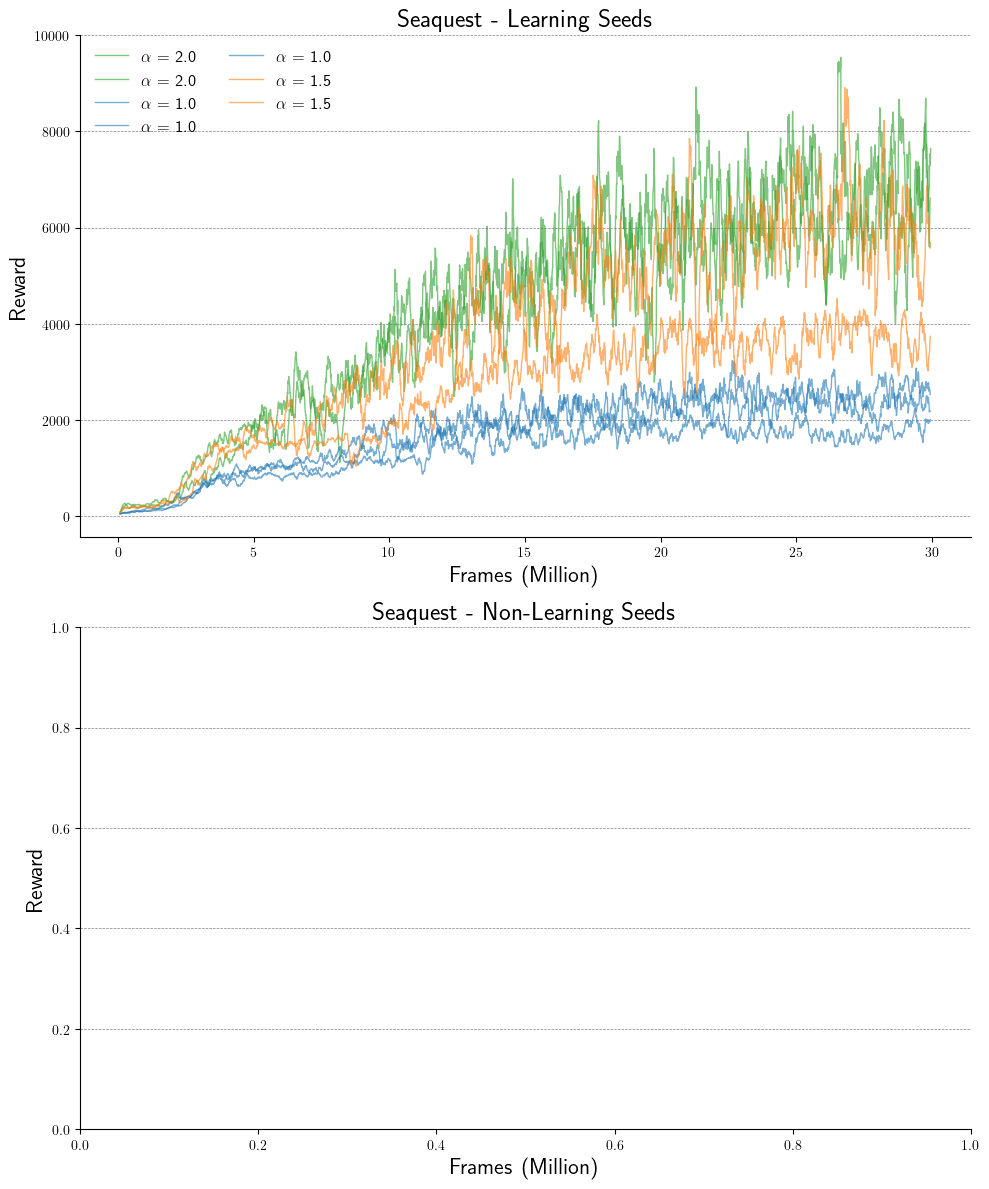

In [6]:
# color mapping
colors = {'5.0': 'C3', '2.0': 'C2', '1.5': 'C1', '1.0': 'C0'}

def plot_seeds(ax, seeds, title, scalar, window_size):
    for df, alpha in seeds:
        steps_transformed = df['step_transformed'].values
        smoothed_values = df['value'].rolling(window=window_size, center=True).mean().values
        valid_indices = ~np.isnan(smoothed_values)
        steps_transformed = steps_transformed[valid_indices]
        smoothed_values = smoothed_values[valid_indices]
        color = colors[alpha]
        ax.plot(steps_transformed, smoothed_values, label=f'$\\alpha$ = {alpha}', linewidth=1, alpha=0.6, color=color)

    ax.set_xlabel('Frames (Million)', fontsize=16)
    ax.set_ylabel(scalar, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax.xaxis.grid(False)

    if scalar == 'Reward':
        ax.legend(loc='upper left', frameon=False, fontsize=12, ncol=2)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

plot_seeds(ax1, learning_seeds, f'{env} - Learning Seeds', scalar, window_size)
plot_seeds(ax2, non_learning_seeds, f'{env} - Non-Learning Seeds', scalar, window_size)

plt.tight_layout()
plt.show()

# Final Plots

In [7]:
# Define constants and configuration
window_size = 50

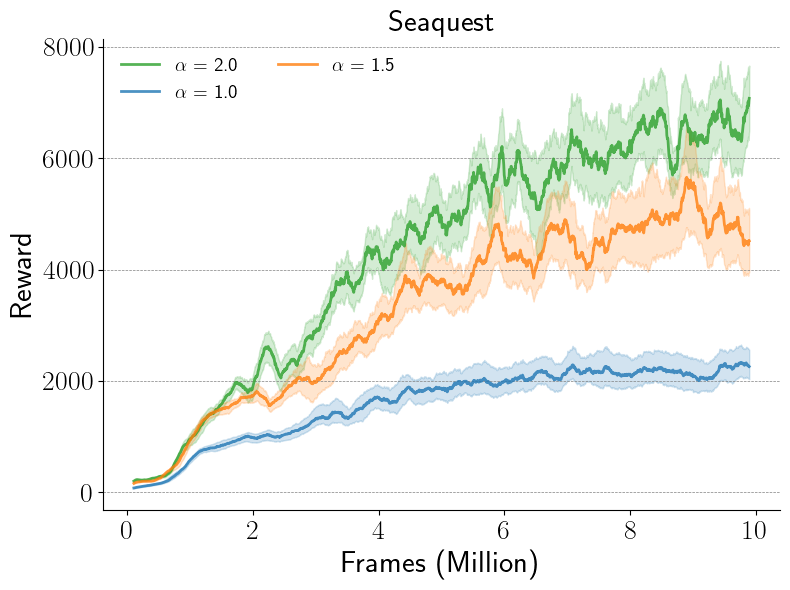

In [8]:
def prepare_data_by_alpha(scalar, scaling_factor, temperature):
    data_by_alpha = {}
    for i, global_results in enumerate(all_global_results):
        _, _, temp, _, alpha, _, seed = runs[i].split('_')
        if alpha not in data_by_alpha:
            data_by_alpha[alpha] = []

        if float(temp) == temperature:
            global_results[scalar.lower()]['step_transformed'] = (global_results[scalar.lower()]['step']) * 4 / 1e6
            data_by_alpha[alpha].append(global_results[scalar.lower()] * scaling_factor)

    return data_by_alpha

# Prepare the data_by_alpha dictionary with 'Reward' data
data_by_alpha = prepare_data_by_alpha('Reward', scaling_factors[env], temperature)


def identify_learning_seeds(data_by_alpha, window_size=10, threshold=10):
    learning_seeds_by_alpha = {}

    for alpha, dfs in data_by_alpha.items():
        min_length = min(df.shape[0] for df in dfs)

        for df in dfs:
            trimmed_df = df.iloc[:min_length]
            steps_transformed = trimmed_df['step_transformed'].values
            smoothed_values = trimmed_df['value'].rolling(window=window_size, center=True).mean().values

            valid_indices = ~np.isnan(smoothed_values)
            steps_transformed = steps_transformed[valid_indices]
            smoothed_values = smoothed_values[valid_indices]

            # Linear regression on reward curve
            A = np.vstack([steps_transformed, np.ones(len(steps_transformed))]).T
            slope, intercept = np.linalg.lstsq(A, smoothed_values, rcond=None)[0]

            if np.abs(slope) >= threshold:
                if alpha not in learning_seeds_by_alpha:
                    learning_seeds_by_alpha[alpha] = []
                learning_seeds_by_alpha[alpha].append(df)

    return learning_seeds_by_alpha

# Identify learning seeds
learning_seeds_by_alpha = identify_learning_seeds(data_by_alpha, window_size, threshold)


def plot_metric(learning_seeds, metric, filename, window_size, scaling_factor):
    plt.figure(figsize=(8, 6))

    for alpha, dfs in learning_seeds.items():
        # Ensure all DataFrames have the same number of rows
        min_length = min(df.shape[0] for df in dfs)
        trimmed_dfs = [df.iloc[:min_length] for df in dfs]
        concatenated_df = pd.concat(trimmed_dfs, ignore_index=True)

        # Debug: Print out the available columns to verify the correct column is being accessed

        # Calculate statistics
        median_vals = concatenated_df.groupby('step_transformed').median()

        # Check if the metric column exists before proceeding
        if metric.lower() not in concatenated_df.columns:
            raise KeyError(f"Column not found: {metric.lower()}. Available columns are: {concatenated_df.columns}")

        lower_quantile = concatenated_df.groupby('step_transformed')[metric.lower()].quantile(0.25)
        upper_quantile = concatenated_df.groupby('step_transformed')[metric.lower()].quantile(0.75)

        # Smooth the statistics
        median_vals_smoothed = median_vals[metric.lower()].rolling(window=window_size, center=True).mean()
        lower_quantile_smoothed = lower_quantile.rolling(window=window_size, center=True).mean()
        upper_quantile_smoothed = upper_quantile.rolling(window=window_size, center=True).mean()

        # Plot
        steps_transformed = median_vals.index
        color = colors[alpha]
        plt.plot(steps_transformed / scaling_factor, median_vals_smoothed, label=f'$\\alpha$ = {alpha}', linewidth=2, alpha=0.8, color=color)
        plt.fill_between(steps_transformed / scaling_factor, 
                         lower_quantile_smoothed, 
                         upper_quantile_smoothed, color=color, alpha=0.2)

    plt.xlabel('Frames (Million)', fontsize=22)
    plt.ylabel('Reward', fontsize=22)
    plt.title(env, fontsize=22)
    plt.tick_params(axis='both', which='major', labelsize=20)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.gca().yaxis.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.gca().xaxis.grid(False)

    plt.tight_layout()
    plt.legend(loc='upper left',frameon=False, fontsize=14, ncol=2)
    if env == 'Boxing':
        plt.ylim(0, 100)
    plt.savefig(f'{filename}.pdf')
    plt.show()

# Plot and save Reward (using 'value' as the column name)
plot_metric(learning_seeds_by_alpha, 'value', f'{env}_reward', window_size, scaling_factor)

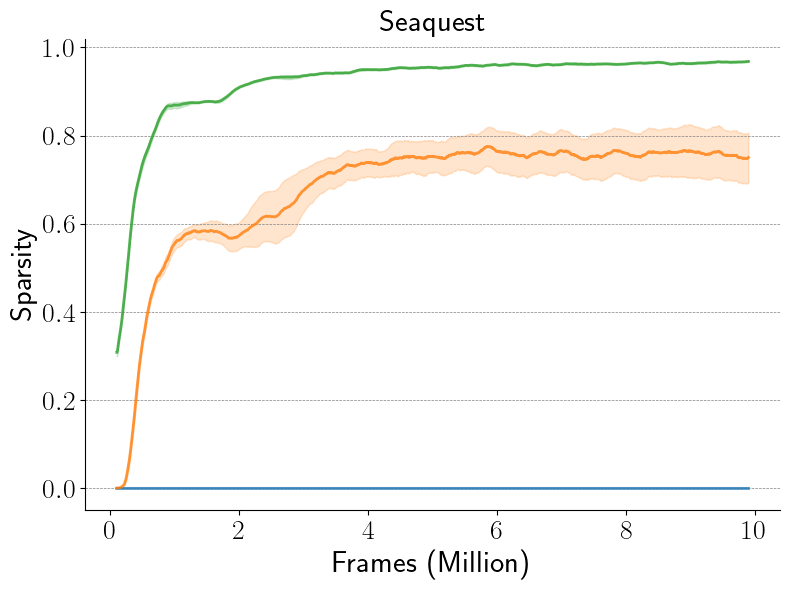

In [9]:
# Helper function to plot with good seeds, allowing selection of alphas
def plot_metric(learning_seeds, metric, filename, window_size, scaling_factor, selected_alphas):
    plt.figure(figsize=(8, 6))

    for alpha, dfs in learning_seeds.items():
        if alpha not in selected_alphas:
            continue

        # Ensure all DataFrames have the same number of rows
        min_length = min(df.shape[0] for df in dfs)
        trimmed_dfs = [df.iloc[:min_length] for df in dfs]
        concatenated_df = pd.concat(trimmed_dfs, ignore_index=True)

        # Calculate statistics
        median_vals = concatenated_df.groupby('step_transformed').median()
        lower_quantile = concatenated_df.groupby('step_transformed')['value'].quantile(0.25)
        upper_quantile = concatenated_df.groupby('step_transformed')['value'].quantile(0.75)

        # Smooth the statistics
        median_vals_smoothed = median_vals['value'].rolling(window=window_size, center=True).mean()
        lower_quantile_smoothed = lower_quantile.rolling(window=window_size, center=True).mean()
        upper_quantile_smoothed = upper_quantile.rolling(window=window_size, center=True).mean()

        # Plot
        steps_transformed = median_vals.index
        color = colors[alpha]
        plt.plot(steps_transformed / scaling_factor, median_vals_smoothed, label=f'$\\alpha$ = {alpha}', linewidth=2, alpha=0.8, color=color)
        plt.fill_between(steps_transformed / scaling_factor, 
                         lower_quantile_smoothed, 
                         upper_quantile_smoothed, color=color, alpha=0.2)

    plt.xlabel('Frames (Million)', fontsize=22)
    plt.ylabel(metric.capitalize(), fontsize=22)
    plt.title(env, fontsize=22)
    plt.tick_params(axis='both', which='major', labelsize=20)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.gca().yaxis.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.gca().xaxis.grid(False)

    if metric.lower() == 'reward':
        plt.legend(loc='upper left', frameon=False, fontsize=14, ncol=2)

    plt.tight_layout()
    plt.savefig(f'{filename}.pdf')
    plt.show()

# Main execution
selected_alphas = ['1.5', '2.0', '1.0']  # You can change this list to include the alphas you want to plot

# Prepare data and plot for Sparsity
scalar = 'Sparsity'
scaling_factor = 1  # Set specific scaling for sparsity

# Prepare data by filtering only the good seeds
data_by_alpha = prepare_data_by_alpha(scalar, scaling_factor, temperature)

# Plot and save Sparsity with selected alphas
plot_metric(data_by_alpha, scalar, f'{env}_{scalar.lower()}', window_size, scaling_factor, selected_alphas)


# Results for Table

In [10]:
def calculate_final_step_stats(learning_seeds_by_alpha):
    final_step_stats = []

    for alpha, dfs in learning_seeds_by_alpha.items():
        final_values = []
        for df in dfs:
            final_value = df['value'].iloc[-1] 
            final_values.append(final_value)
        
        mean_final_value = np.mean(final_values)
        std_final_value = np.std(final_values)
        
        final_step_stats.append({
            'Alpha': alpha,
            'Mean': mean_final_value,
            'Std': std_final_value
        })

    df_stats = pd.DataFrame(final_step_stats)
    df_stats = df_stats.sort_values('Alpha') 
    return df_stats


df_final_stats = calculate_final_step_stats(learning_seeds_by_alpha)
df_final_stats

,Alpha,Mean,Std
1,1.0,2033.333374,73.635738
2,1.5,4899.375000,219.375000
0,2.0,8955.000000,204.999756


In [11]:
df_final_stats.to_csv(f'benchmark_{game}.csv')